# 14 - ANOVA

<center><img src="img/anovaa.png" alt="Testy różnic" width="500"/></center>

# ANOVA w Pythonie – wprowadzenie

Analiza wariancji (**ANOVA**, *Analysis of Variance*) służy do sprawdzania, czy **średnie kilku niezależnych grup** różnią się od siebie istotnie statystycznie. Porównujemy dwa źródła zmienności:

- **Między grupami (Between Groups)** – zmienność wynikająca z różnic między średnimi grup  
- **Wewnątrz grup (Within Groups / Residual)** – zmienność wynikająca z indywidualnych różnic w obrębie każdej grupy  

Statystyka testowa ma postać:

$$
F = \frac{MS_{\text{between}}}{MS_{\text{within}}}
$$

gdzie:

$$
MS = \frac{SS}{df}
$$

Duża wartość statystyki *F* sugeruje, że średnie w grupach różnią się bardziej, niż wynikałoby to z przypadku.

---

## Hipotezy w jednoczynnikowej ANOVA

- **H₀:** wszystkie średnie populacyjne są równe  
$$
  \mu_1 = \mu_2 = \dots = \mu_k
$$

- **H₁:** co najmniej dwie średnie różnią się między sobą

---

## Tabela ANOVA 

| Źródło zmienności | SS (Sum of Squares) | df  | MS (Mean Square)              | F                           | p-value |
|-------------------|---------------------|-----|-------------------------------|-----------------------------|---------|
| Between Groups    | SS_between          | k-1 | SS_between/(k-1)              | MS_between/MS_within        | p       |
| Within Groups     | SS_within           | N-k | SS_within/(N-k)               | —                           | —       |
| Total             | SS_total            | N-1 | —                             | —                           | —       |

Gdzie:  
- `k` – liczba porównywanych grup  
- `N` – łączna liczba obserwacji

---

<center><img src="img/anova.png" alt="Testy różnic" width="500"/></center>

---

## Przykład 1.

Dane pochodzą z amerykańskiego magazynu Motor Trend z 1974 roku i obejmują zużycie paliwa oraz 10 cech związanych z konstrukcją i osiągami 32 samochodów (modele z lat 1973–74).

W analizie chcemy rozważyć możliwe różnice w liczbie mil na galon (mpg) pomiędzy wybranymi grupami kontrolnymi, takimi jak liczba cylindrów.

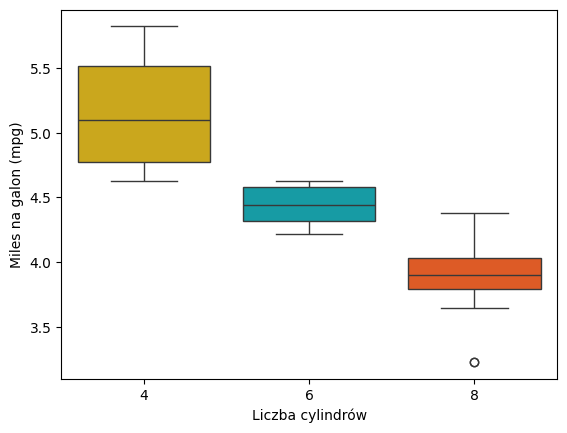

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Wczytanie danych mtcars
url = "https://raw.githubusercontent.com/selva86/datasets/master/mtcars.csv"
mtcars = pd.read_csv(url)

# Zamiana liczby cylindrów na tekst
mtcars['cyl'] = mtcars['cyl'].astype(str)

# Wykres pudełkowy zgodny z nowszą wersją seaborn
sns.boxplot(
    x='cyl',
    y='mpg',
    hue='cyl',          # <- wymagane, jeśli używasz palette
    data=mtcars,
    palette=["#00AFBB", "#E7B800", "#FC4E07"],
    order=["4", "6", "8"],
    legend=False        # <- wyłącza niepotrzebną legendę
)

plt.xlabel("Liczba cylindrów")
plt.ylabel("Miles na galon (mpg)")

plt.show()


Zacznijmy najpierw od spojrzenia na przedziały ufności:

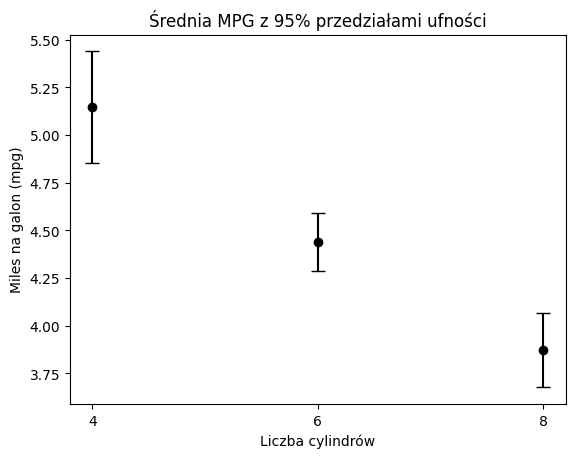

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

# Obliczenie średnich i 95% CI dla mpg w grupach cylindrów
means = mtcars.groupby('cyl')['mpg'].mean()
conf_intervals = mtcars.groupby('cyl')['mpg'].apply(lambda x: DescrStatsW(x).tconfint_mean())

# Ekstrakcja dolnej i górnej granicy CI
lower_bounds = conf_intervals.apply(lambda x: x[0])
upper_bounds = conf_intervals.apply(lambda x: x[1])

# Wykres punktowy ze słupkami błędów (95% CI)
plt.errorbar(
    means.index,
    means,
    yerr=[means - lower_bounds, upper_bounds - means],
    fmt='o',
    capsize=5,
    color='black'
)

plt.xlabel("Liczba cylindrów")
plt.ylabel("Miles na galon (mpg)")
plt.title("Średnia MPG z 95% przedziałami ufności")

plt.show()


### 1-way Anova

Chcemy sprawdzić, czy istnieją jakiekolwiek istotne różnice pomiędzy średnią liczbą mil na galon w trzech typach samochodów (różniących się liczbą cylindrów).

Zacznijmy od sprawdzenia normalności rozkładu.

In [5]:
import pandas as pd
from scipy.stats import shapiro

# Grupujemy dane wg liczby cylindrów ('cyl') i wykonujemy test Shapiro–Wilka
# dla zmiennej 'mpg' w każdej grupie
shapiro_results = mtcars.groupby('cyl')['mpg'].apply(lambda x: shapiro(x))

# Tworzymy DataFrame z wynikami testu
shapiro_df = pd.DataFrame({
    'cyl': shapiro_results.index,
    'W': [result[0] for result in shapiro_results],
    'p-value': [result[1] for result in shapiro_results]
})

print(shapiro_df)


  cyl         W   p-value
0   4  0.915339  0.281708
1   6  0.898284  0.320719
2   8  0.915158  0.187208


Możemy również obejrzeć wykresy Q–Q sprawdzające normalność, razem z wynikami testu Shapiro–Wilka:

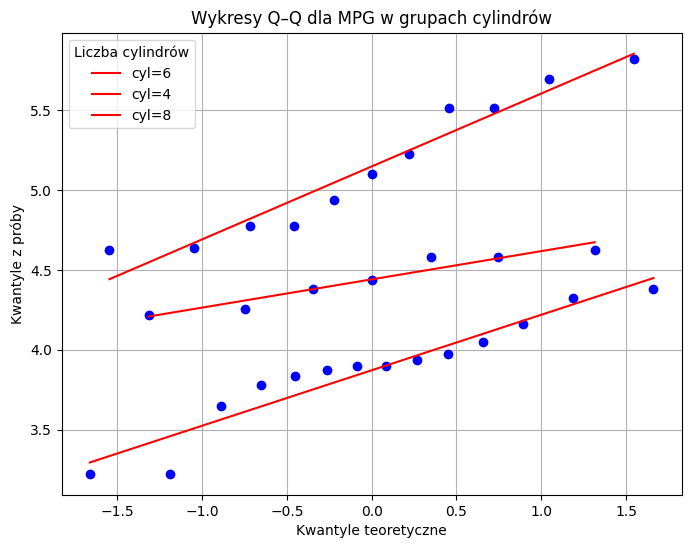

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Tworzymy wykresy Q–Q z linią odniesienia dla każdej grupy cylindrów
plt.figure(figsize=(8, 6))
for cyl in mtcars['cyl'].unique():
    subset = mtcars[mtcars['cyl'] == cyl]
    stats.probplot(subset['mpg'], dist="norm", plot=plt)
    plt.gca().get_lines()[-1].set_label(f'cyl={cyl}')  # etykieta dla legendy

plt.legend(title='Liczba cylindrów')
plt.xlabel('Kwantyle teoretyczne')
plt.ylabel('Kwantyle z próby')
plt.title('Wykresy Q–Q dla MPG w grupach cylindrów')
plt.grid(True)
plt.show()


- Nie widzimy żadnych odchyleń od linii normalności, a wartości p również sugerują brak podstaw do odrzucenia normalności.

- Kolejnym krokiem jest przetestowanie założenia o jednorodności wariancji. 

- Zdecydowanie polecam test Levene’a, który jest mniej wrażliwy na odchylenia od normalnego rozkładu.

In [8]:
from scipy.stats import levene
# Wykonanie testu Levene’a na równość wariancji
stat, p_value = levene(
    mtcars[mtcars['cyl'] == '4']['mpg'],
    mtcars[mtcars['cyl'] == '6']['mpg'],
    mtcars[mtcars['cyl'] == '8']['mpg']
)

print(f"Statystyka testu Levene’a: {stat}")
print(f"Wartość p: {p_value}")

Statystyka testu Levene’a: 2.868889131775262
Wartość p: 0.07296950644913475


Wartość p jest tylko nieco wyższa od naszego progu istotności α = 0.05, więc jeśli chcesz przeprowadzić bardziej odporną wersję ANOVA — czyli ANOVA Welcha — uruchom funkcję z biblioteki pingouin:

In [9]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA using statsmodels
model = ols('mpg ~ cyl', data=mtcars).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_results)

             sum_sq    df          F        PR(>F)
cyl       10.013559   2.0  41.055426  3.477779e-09
Residual   3.536600  29.0        NaN           NaN


Jak widzimy, co najmniej jedna para średnich różni się istotnie statystycznie (H0 powinna zostać odrzucona). Oznacza to, że liczba mil na galon istotnie różni się pomiędzy samochodami o różnej liczbie cylindrów.

Skoro odrzuciliśmy H0, możemy przeprowadzić testy post-hoc: LSD (least-significant-differences) lub HSD (honestly-significant-differences).

Test Tukeya HSD służy do porównania wszystkich grup ze sobą — czyli wykonuje wszystkie możliwe porównania par 2 grup.

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      6  -0.7064 0.0007 -1.1234 -0.2894   True
     4      8   -1.275    0.0 -1.6224 -0.9275   True
     6      8  -0.5686  0.004 -0.9678 -0.1693   True
----------------------------------------------------


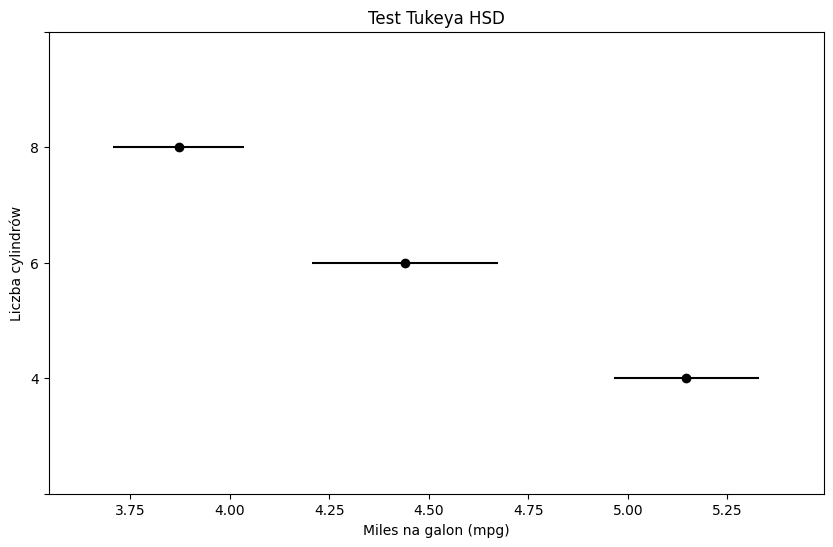

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Wykonanie testu Tukeya HSD
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Wyświetlenie wyników
print(tukey)

# Wykres wyników testu
tukey.plot_simultaneous()
plt.title('Test Tukeya HSD')
plt.xlabel('Miles na galon (mpg)')
plt.ylabel('Liczba cylindrów')
plt.show()


Jak widzimy powyżej, wszystkie pary średnich różnią się istotnie statystycznie (p < α).

Na koniec zwizualizujmy nasze wyniki razem z testem ANOVA oraz testami post-hoc:

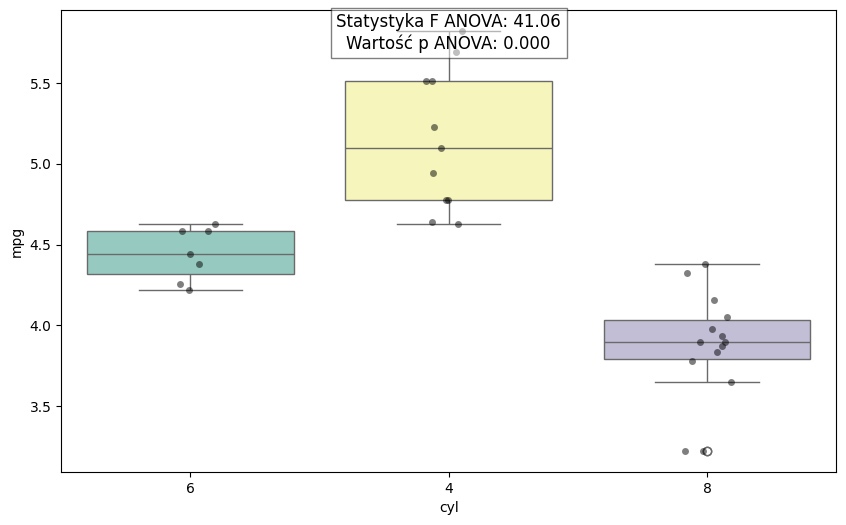

In [12]:
# Wykonanie testu Tukeya HSD
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Wizualizacja wyników
plt.figure(figsize=(10, 6))

# Boxplot: nowe wymagania seaborn
sns.boxplot(
    x='cyl',
    y='mpg',
    hue='cyl',
    data=mtcars,
    palette="Set3",
    legend=False
)

sns.stripplot(
    x='cyl',
    y='mpg',
    data=mtcars,
    color='black',
    jitter=True,
    alpha=0.5
)

# Dodanie wyników ANOVA
anova_text = (
    f"Statystyka F ANOVA: {anova_results['F'].iloc[0]:.2f}\n"
    f"Wartość p ANOVA: {anova_results['PR(>F)'].iloc[0]:.3f}"
)

plt.text(
    0.5, 0.95, anova_text,
    horizontalalignment='center',
    verticalalignment='center',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.show()


Zrób to sam (DIY):

A co z am (typ skrzyni biegów) i liczbą biegów (gear)?

In [13]:
# Twój kod tutaj!

---

## Zadanie 1. Twoja kolej!

Poniższy zbiór danych przedstawia wyniki dotyczące satysfakcji z pracy, uporządkowane według płci oraz poziomu wykształcenia.

W tym badaniu badacz chce ocenić, czy istnieje istotna dwuczynnikowa interakcja pomiędzy płcią a poziomem wykształcenia w wyjaśnianiu poziomu satysfakcji z pracy.

Efekt interakcji pojawia się wtedy, gdy wpływ jednej zmiennej niezależnej na zmienną wynikową zależy od poziomu drugiej zmiennej niezależnej.

Jeśli efektu interakcji nie ma, można raportować efekty główne.


In [14]:
import pandas as pd

# Wczytanie zbioru danych jobsatisfaction z mojego repozytorium GitHub:
url = "https://raw.githubusercontent.com/kflisikowski/ds/master/jobsatisfaction.csv"
jobsatisfaction = pd.read_csv(url)

In [15]:
# Twój kod tutaj!

---

## Wprowadzenie do Repeated Measures ANOVA

**Repeated Measures ANOVA** (ANOVA z powtarzanymi pomiarami) to metoda analizy statystycznej wykorzystywana wtedy, gdy **te same jednostki** (np. ci sami uczestnicy badania) są mierzone **w wielu warunkach** lub **w kilku punktach czasowych**.  
Oznacza to, że obserwacje są **zależne**, bo pochodzą od tych samych osób.

### 🔍 Kiedy stosujemy RM ANOVA?

RM ANOVA jest odpowiednia, gdy badacz chce sprawdzić, czy istnieją istotne różnice pomiędzy średnimi wartościami zmiennej zależnej w różnych pomiarach wykonanych na tej samej grupie.  
Przykłady:
- wynik testu mierzony **przed szkoleniem**, **po szkoleniu** i **miesiąc po szkoleniu**,  
- ciśnienie krwi mierzone **w spoczynku**, **po wysiłku**, **w trakcie regeneracji**,  
- ocena nastroju uczestników **rano**, **po południu** i **wieczorem**.

### ⭐ Dlaczego używamy tej metody?

Ponieważ ci sami uczestnicy pojawiają się w każdej kondycji, RM ANOVA:
- **eliminuje wpływ różnic indywidualnych** (każdy jest „swoją własną kontrolą”),  
- zwiększa **moc testu**,  
- wymaga mniejszej liczby uczestników niż klasyczne ANOVA międzygrupowe.

### 📌 Założenia RM ANOVA

1. **Normalność** rozkładu różnic pomiędzy pomiarami.  
2. **Sferyczność** (sphericity): wariancje różnic między wszystkimi parami warunków powinny być równe.  
   - Gdy założenie jest naruszone, stosuje się poprawki:  
     - **Greenhouse–Geisser**,  
     - **Huynh–Feldt**.

### 🧪 Co testuje RM ANOVA?

RM ANOVA sprawdza, czy średnie z różnych pomiarów **różnią się od siebie istotnie statystycznie**, czyli czy istnieje efekt czasu/warunku.

Jeśli wynik ANOVA jest istotny ⇒ wykonujemy **testy post-hoc**, aby sprawdzić, które pomiary różnią się między sobą.

---

## RM ANOVA w Pythonie

Kluczowe funkcje w Pythonie:

### statsmodels

**AnovaRM**: funkcja dostępna w pakiecie *statsmodels*, służy do przeprowadzania analizy wariancji z powtarzanymi pomiarami (Repeated Measures ANOVA).

```python
from statsmodels.stats.anova import AnovaRM


### pingouin

**rm_anova**: funkcja z biblioteki *pingouin*, również służy do przeprowadzania analizy RM ANOVA (ANOVA z powtarzanymi pomiarami).

```python
result = pg.rm_anova(dv='dependent_variable',
                     within='within_factor',
                     subject='subject',
                     data=data)

print(result)


---

## 1-way RM ANOVA

Zbiór danych **„selfesteem”** zawiera wyniki samooceny 10 osób,
zmierzone w trzech momentach czasowych podczas stosowania określonej diety,
aby sprawdzić, czy ich samoocena uległa poprawie.


In [16]:
import pandas as pd

# Adres URL do pliku CSV
url = "https://github.com/kflisikowski/ds/raw/master/selfesteem.csv"

# Wczytanie danych do DataFrame
selfesteem = pd.read_csv(url)

# Wyświetlenie pierwszych kilku wierszy danych
print(selfesteem.head())


   id        t1        t2        t3
0   1  4.005027  5.182286  7.107831
1   2  2.558124  6.912915  6.308434
2   3  3.244241  4.443434  9.778410
3   4  3.419538  4.711696  8.347124
4   5  2.871243  3.908429  6.457287


Jednoczynnikowa ANOVA z powtarzanymi pomiarami może zostać użyta do sprawdzenia, czy średnie poziomy samooceny różnią się istotnie pomiędzy trzema momentami pomiaru. Dlatego najpierw przekształćmy ramkę danych do formatu „long”.

In [17]:
# Przekształcenie danych do formatu long
selfesteem = selfesteem.melt(id_vars=['id'], value_vars=['t1', 't2', 't3'],
                             var_name='time', value_name='score')

# Konwersja kolumn 'id' oraz 'time' na typ kategoryczny
selfesteem['id'] = selfesteem['id'].astype('category')
selfesteem['time'] = selfesteem['time'].astype('category')

# Wyświetlenie pierwszych 3 wierszy przekształconych danych
print(selfesteem.head(3))


  id time     score
0  1   t1  4.005027
1  2   t1  2.558124
2  3   t1  3.244241


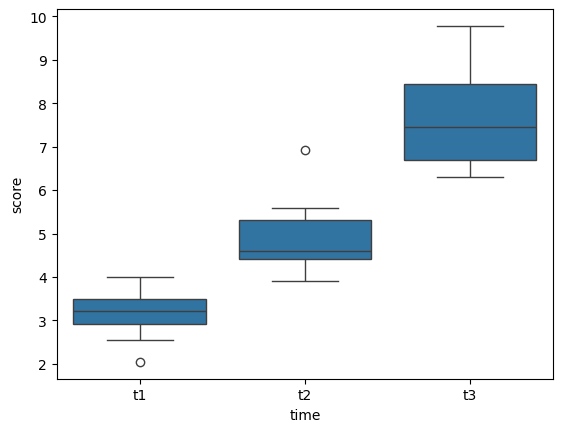

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tworzenie wykresu pudełkowego
bxp = sns.boxplot(x='time', y='score', data=selfesteem)

# Wyświetlenie wykresu
plt.show()


## Założenia

In [23]:
def identify_outliers(group):
    Q1 = group['score'].quantile(0.25)
    Q3 = group['score'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (group['score'] < (Q1 - 1.5 * IQR)) | (group['score'] > (Q3 + 1.5 * IQR))

    # kolumna 'time' została usunięta przez include_groups=False → dodajemy ją z nazwy grupy:
    result = group.loc[outliers].copy()
    result['time'] = group.name
    return result[['id', 'time', 'score']]

outliers = (
    selfesteem.groupby('time', observed=True)
              .apply(identify_outliers, include_groups=False)
              .reset_index(drop=True)
)

print(outliers)


  id time     score
0  6   t1  2.045868
1  2   t2  6.912915


In [27]:
import pingouin as pg

shapiro_results = selfesteem.groupby('time', observed=True).apply(
    lambda x: pg.normality(x['score'], method='shapiro'),
    include_groups=False
)

print(shapiro_results)


                   W      pval  normal
time                                  
t1   score  0.966690  0.858576    True
t2   score  0.875885  0.116996    True
t3   score  0.922715  0.380156    True


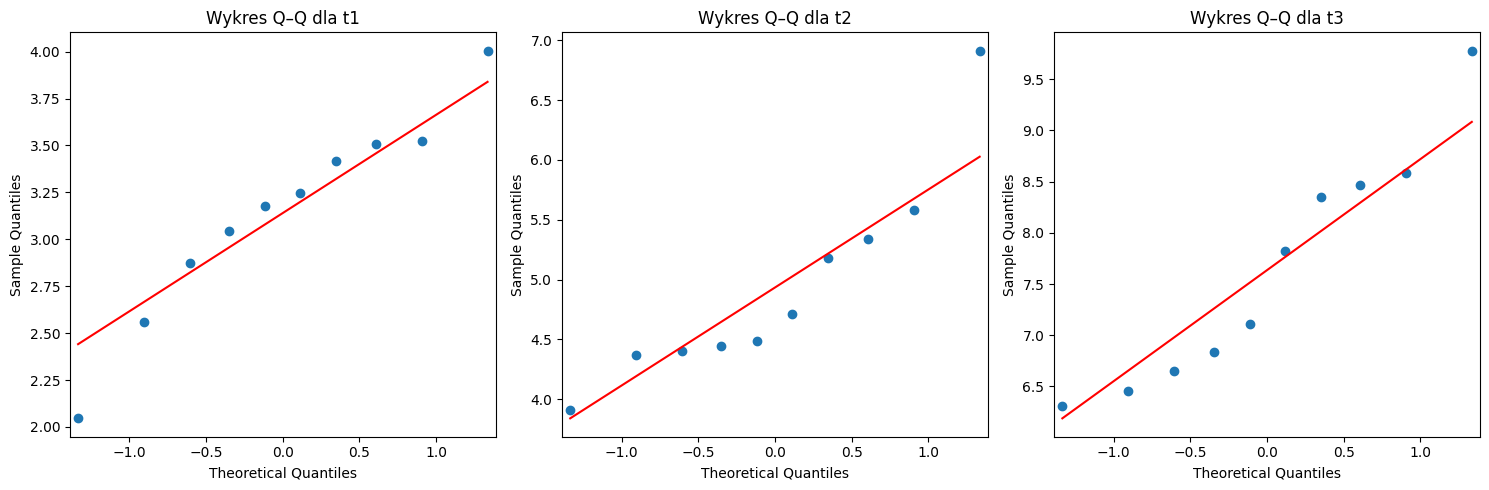

In [28]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Tworzenie wykresów Q–Q dla każdej grupy czasowej
time_groups = selfesteem['time'].unique()
fig, axes = plt.subplots(1, len(time_groups), figsize=(15, 5))

for i, time in enumerate(time_groups):
    sm.qqplot(selfesteem[selfesteem['time'] == time]['score'], line='s', ax=axes[i])
    axes[i].set_title(f'Wykres Q–Q dla {time}')

plt.tight_layout()
plt.show()


### 🌀 Sphericity (sferyczność)

**Sferyczność** to jedno z kluczowych założeń jednoczynnikowej ANOVA z powtarzanymi pomiarami (RM ANOVA).

### 🔍 Co oznacza sferyczność?

Sferyczność oznacza, że:

> **wariancje różnic pomiędzy wszystkimi parami poziomów czynnika wewnątrzobiektowego są takie same.**

Czyli:
- różnice między t1 a t2 mają podobną wariancję,
- różnice między t1 a t3 mają podobną wariancję,
- różnice między t2 a t3 mają podobną wariancję.

Jeśli te wariancje są zbliżone — założenie sferyczności jest spełnione.

### 🧪 Jak testujemy sferyczność?

Najczęściej używa się do tego:

- **testu Mauchly’ego** (Mauchly's Test of Sphericity)

Jeżeli wynik testu jest istotny (p < 0.05), oznacza to, że:

❌ sferyczność jest naruszona.

### 🔧 Co jeśli sferyczności nie ma?

RM ANOVA jest wtedy zbyt liberalna (zaniżone p-value).  
W takim przypadku stosujemy poprawki:

- **Greenhouse–Geisser**
- **Huynh–Feldt**

Dają one bardziej konserwatywne wyniki i „korygują” stopnie swobody, aby ANOVA była wiarygodna mimo naruszenia sferyczności.

### 📌 Podsumowanie

- Sferyczność dotyczy *różnic między poziomami*, a nie samych poziomów.  
- Naruszenie tego założenia jest bardzo częste przy co najmniej 3 pomiarach.  
- Jeśli sferyczność jest naruszona → używamy korekt GG lub HF.  
- Biblioteka `pingouin` automatycznie podaje wyniki z korektami.



In [29]:
import pingouin as pg
spher = pg.sphericity(selfesteem, dv='score', subject='id', within='time')
print(spher)

SpherResults(spher=True, W=np.float64(0.5508534046691561), chi2=np.float64(4.770292467677472), dof=2, pval=np.float64(0.09207551403887483))


Jeśli wartość p jest mniejsza niż 0.05, oznacza to, że założenie sferyczności zostało naruszone i należy zastosować odpowiednią korektę stopni swobody (np. korektę Greenhouse’a–Geissera).

Jeśli wartość p jest większa niż 0.05, oznacza to, że założenie sferyczności jest spełnione.

In [30]:
# Wykonanie jednoczynnikowej ANOVA z powtarzanymi pomiarami
results = pg.rm_anova(data=selfesteem, dv='score', within='time', subject='id')

# Wyświetlenie wyników
print(results)


  Source  ddof1  ddof2          F         p-unc       ng2       eps
0   time      2     18  55.469027  2.013829e-08  0.828595  0.690061


## Jak interpretować wyniki RM ANOVA?

**Source:** Źródło wariancji. W tym przypadku jest to `time`, co oznacza analizę wpływu czasu na zmienną `score`.

**ddof1:** Stopnie swobody dla czynnika `time` (df_between).  
Ponieważ mamy trzy pomiary (t1, t2, t3), to:  
**df_between = liczba poziomów – 1 = 3 – 1 = 2**.

**ddof2:** Stopnie swobody dla błędu (df_within).  
Wynosi **18**, co wynika z liczby uczestników przemnożonej przez (liczba poziomów – 1).

**F:** Statystyka F. Informuje, jak duże są różnice między średnimi w stosunku do zmienności wewnątrz grup. Wyższa wartość F wskazuje na większe różnice między pomiarami.

**p-unc:** Wartość p (niekorygowana).  
Pokazuje, czy różnice między pomiarami są statystycznie istotne.  
**p < 0.05** oznacza istotne różnice.

**np2:** Eta-kwadrat (η²) — miara wielkości efektu.  
Informuje, jaka część wariancji wyników może być wyjaśniona przez czynnik `time`.

Interpretacja eta-square:
- **0.01** — mały efekt  
- **0.06** — średni efekt  
- **0.14** — duży efekt


### Testy post-hoc

In [31]:
# Wykonanie porównań post-hoc z korektą Bonferroniego
pwc = pg.pairwise_tests(dv='score', within='time', subject='id',
                        data=selfesteem, padjust='bonferroni')

# Wyświetlenie wyników
print(pwc)


  Contrast   A   B  Paired  Parametric          T  dof alternative  \
0     time  t1  t2    True        True  -4.967618  9.0   two-sided   
1     time  t1  t3    True        True -13.228148  9.0   two-sided   
2     time  t2  t3    True        True  -4.867816  9.0   two-sided   

          p-unc    p-corr    p-adjust      BF10    hedges  
0  7.724196e-04  0.002317  bonferroni    50.694 -2.371801  
1  3.343804e-07  0.000001  bonferroni  4.02e+04 -4.799517  
2  8.861912e-04  0.002659  bonferroni    45.195 -2.556194  


/var/folders/52/jywb2x0n3tbfhc83q6yhpn5c0000gn/T/ipykernel_10190/754861677.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time', y='score', data=selfesteem, palette="Set3")


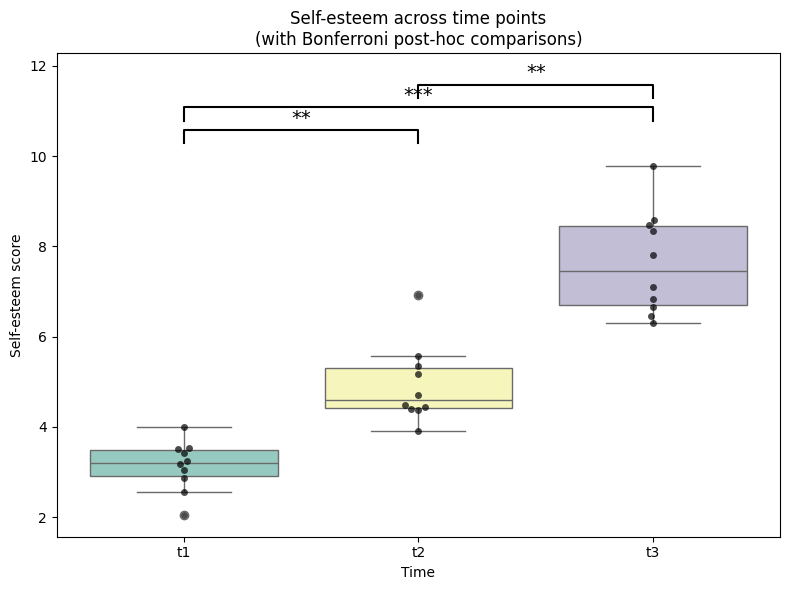

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Podstawowy wykres: boxplot + swarm (rozrzut punktów)
plt.figure(figsize=(8, 6))
sns.boxplot(x='time', y='score', data=selfesteem, palette="Set3")
sns.swarmplot(x='time', y='score', data=selfesteem, color='black', alpha=0.7)

# Wyciągnięcie istotnych par z post-hoc
sig_pairs = pwc[pwc['p-corr'] < 0.05][['A','B','p-corr']]

# Funkcja rysująca adnotacje nad wykresem
def add_sig_annotation(x1, x2, y, p):
    plt.plot([x1, x1, x2, x2], [y, y+0.3, y+0.3, y], lw=1.5, c='black')
    
    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = "ns"
        
    plt.text((x1 + x2)/2, y + 0.35, label, ha='center', va='bottom', fontsize=14)

# Ustalanie wysokości adnotacji
ymax = selfesteem['score'].max()
step = 0.5
current_y = ymax + 0.5

# Dodawanie anotacji dla istotnych par
for _, row in sig_pairs.iterrows():
    x1 = int(row['A'][-1]) - 1   # t1 → 0, t2 → 1, t3 → 2
    x2 = int(row['B'][-1]) - 1
    add_sig_annotation(x1, x2, current_y, row['p-corr'])
    current_y += step

plt.title("Self-esteem across time points\n(with Bonferroni post-hoc comparisons)")
plt.xlabel("Time")
plt.ylabel("Self-esteem score")
plt.ylim(top=current_y + 0.5)   # żeby się wszystko zmieściło

plt.tight_layout()
plt.show()


## 3-way R-M ANOVA (zadanie domowe)

Wykorzystamy zbiór danych **weightloss** z pakietu *datarium*.

W tym badaniu badacz chciał ocenić wpływ **diety** i **ćwiczeń** na utratę masy ciała u 10 osób prowadzących siedzący tryb życia.

Uczestnicy brali udział w czterech warunkach eksperymentalnych:
1. brak diety i brak ćwiczeń,
2. tylko dieta,
3. tylko ćwiczenia,
4. dieta + ćwiczenia.

Każdy uczestnik przeszedł wszystkie cztery warunki.  
Kolejność warunków została **skontrbalansowana**, a pomiędzy sesjami zapewniono odpowiednio długi czas, aby zminimalizować wpływ poprzednich prób.

Każdy warunek trwał dziewięć tygodni.  
Poziom utraty masy ciała mierzono w trzech momentach:
- **t1** – początek programu,
- **t2** – punkt środkowy,
- **t3** – koniec programu.



In [37]:
import pandas as pd

# URL do pliku CSV
url = "https://github.com/kflisikowski/ds/raw/master/weightloss.csv"

# Wczytanie danych do DataFrame
weightloss = pd.read_csv(url)

# Wyświetlenie pierwszych kilku wierszy danych
print(weightloss.head())

   id diet exercises     t1     t2     t3
0   1   no        no  10.43  13.21  11.59
1   2   no        no  11.59  10.66  13.21
2   3   no        no  11.35  11.12  11.35
3   4   no        no  11.12   9.50  11.12
4   5   no        no   9.50   9.73  12.28


In [40]:
# Przekształcenie danych do formatu long
weightloss_long = weightloss.melt(
    id_vars=['id', 'diet', 'exercises'],
    value_vars=['t1', 't2', 't3'],
    var_name='time',
    value_name='score'
)

# Konwersja 'id' oraz 'time' na typ kategoryczny
weightloss_long['id'] = weightloss_long['id'].astype('category')
weightloss_long['time'] = weightloss_long['time'].astype('category')

# Pobranie przykładowych obserwacji — po jednej z każdej kombinacji diet × ćwiczenia × czas
sampled_data = weightloss_long.groupby(
    ['diet', 'exercises', 'time'],
    observed=True        # <-- usuwa FutureWarning
).sample(n=1, random_state=123)

# Wyświetlenie wyników
print(sampled_data)


     id diet exercises time  score
5     6   no        no   t1   9.50
54    7   no        no   t2  12.51
102   7   no        no   t3  11.59
20    9   no       yes   t1  11.35
67    8   no       yes   t2  14.37
117  10   no       yes   t3  17.38
30    7  yes        no   t1  11.59
79    8  yes        no   t2  11.35
124   5  yes        no   t3  13.90
41    6  yes       yes   t1  10.66
93   10  yes       yes   t2  14.13
136   5  yes       yes   t3  15.29


W tym przykładzie wpływ zmiennej „time” jest naszym głównym obiektem zainteresowania — to on stanowi podstawowy element analizy.

Zakłada się, że wpływ czasu na wynik utraty masy ciała może zależeć od dwóch innych czynników: „diet” oraz „exercises”.

Czynniki te pełnią rolę zmiennych moderujących, czyli takich, które mogą wzmacniać, osłabiać lub zmieniać kierunek efektu czasu.

In [41]:
# Twoje rozwiązanie tutaj!